In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
import sklearn
import tensorflow as tf
from tensorflow import keras


# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "autoencoders"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

2024-03-22 19:07:16.126620: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-22 19:07:16.126713: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-22 19:07:16.262321: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [6]:
def plot_image(image):
    plt.imshow(image, cmap="binary")
    plt.axis("off")

In [7]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train_full = X_train_full.astype(np.float32) / 255
X_test = X_test.astype(np.float32) / 255
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [9]:
def rounded_accuracy(y_true, y_pred):
    return keras.metrics.binary_accuracy(tf.round(y_true), tf.round(y_pred))

In [10]:
def exponential_decay_fn(epoch):
    return 0.01 * 0.1**(epoch / 20)
def exponential_decay(lr0, s):
    def exponential_decay_fn(epoch):
        return lr0 * 0.1**(epoch / s)
    return exponential_decay_fn


In [11]:
def show_reconstructions(model, images=X_valid, n_images=5):
    reconstructions = model.predict(images[:n_images])
    fig = plt.figure(figsize=(n_images * 1.5, 3))
    for image_index in range(n_images):
        plt.subplot(2, n_images, 1 + image_index)
        plot_image(images[image_index])
        plt.subplot(2, n_images, 1 + n_images + image_index)
        plot_image(reconstructions[image_index])

In [12]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)
exponential_decay_fn = exponential_decay(lr0=2, s=20)
Early_stop=keras.callbacks.EarlyStopping(monitor='loss',min_delta=0.0001,patience=3,verbose=1,restore_best_weights=True,start_from_epoch=150)
lr_scheduler = keras.callbacks.LearningRateScheduler(exponential_decay_fn)
conv_encoder = keras.models.Sequential([
    keras.layers.Reshape([28, 28, 1], input_shape=[28, 28]),
    keras.layers.Conv2D(16, kernel_size=3, padding="SAME", activation="relu",kernel_initializer="HeNormal",kernel_regularizer=keras.regularizers.l2(0.01)),
    keras.layers.Dropout(rate=0.1),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=2),
    keras.layers.Conv2D(32, kernel_size=3, padding="SAME", activation="relu",kernel_initializer="HeNormal",kernel_regularizer=keras.regularizers.l2(0.01)),
    keras.layers.Dropout(rate=0.1),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=2),
    keras.layers.Conv2D(64, kernel_size=3, padding="SAME", activation="relu",kernel_initializer="HeNormal",kernel_regularizer=keras.regularizers.l2(0.01)),
    keras.layers.Dropout(rate=0.1),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=2)
])
conv_decoder = keras.models.Sequential([
    keras.layers.Conv2DTranspose(32, kernel_size=3, strides=2, padding="VALID", activation="relu",kernel_initializer="HeNormal",kernel_regularizer=keras.regularizers.l2(0.01),
                                 input_shape=[3, 3, 64]),
    keras.layers.Dropout(rate=0.1),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2DTranspose(16, kernel_size=3, strides=2, padding="SAME", activation="relu",kernel_initializer="HeNormal",kernel_regularizer=keras.regularizers.l2(0.01)),
    keras.layers.Dropout(rate=0.1),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2DTranspose(1, kernel_size=3, strides=2, padding="SAME", activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])
conv_ae = keras.models.Sequential([conv_encoder, conv_decoder])

conv_ae.compile(loss="mse", optimizer=keras.optimizers.Adam(learning_rate=0.0001),#,momentum=0.7),
                metrics=[rounded_accuracy])
history = conv_ae.fit(X_train, X_train, 128,epochs=300,
                      validation_data=(X_valid, X_valid))#,callbacks=[Early_stop]),lr_scheduler])

/opt/conda/lib/python3.10/site-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv_transpose.py:94: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Epoch 1/300
 22/430 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 4.2775 - rounded_accuracy: 0.5205

I0000 00:00:1711134496.276608     108 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


430/430 ━━━━━━━━━━━━━━━━━━━━ 30s 34ms/step - loss: 3.6645 - rounded_accuracy: 0.5873 - val_loss: 2.1550 - val_rounded_accuracy: 0.7310
Epoch 2/300
430/430 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 1.8331 - rounded_accuracy: 0.8408 - val_loss: 1.1179 - val_rounded_accuracy: 0.7679
Epoch 3/300
430/430 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.9475 - rounded_accuracy: 0.8818 - val_loss: 0.6168 - val_rounded_accuracy: 0.7617
Epoch 4/300
430/430 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.5149 - rounded_accuracy: 0.8977 - val_loss: 0.3676 - val_rounded_accuracy: 0.7551
Epoch 5/300
430/430 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.3013 - rounded_accuracy: 0.9070 - val_loss: 0.2424 - val_rounded_accuracy: 0.7599
Epoch 6/300
430/430 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.1948 - rounded_accuracy: 0.9179 - val_loss: 0.1749 - val_rounded_accuracy: 0.7959
Epoch 7/300
430/430 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.1400 - rounded_accuracy: 0.9262 - val_loss: 0.1350 - val_rounded_accuracy: 0.

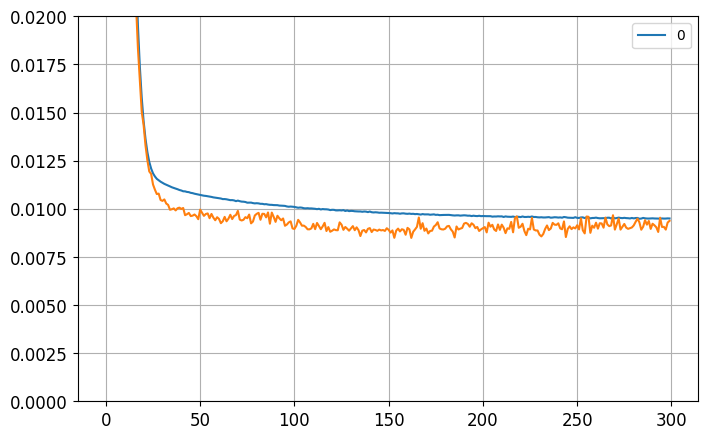

In [14]:
import pandas as pd

pd.DataFrame(history.history["loss"]).plot(figsize=(8, 5))
plt.plot(history.history["val_loss"])
plt.grid(True)
#plt.gca().set_ylim(0, 1)
#save_fig("keras_learning_curves_plot")
#plt.xlim(0,20)
plt.ylim(0,0.02)
plt.show()

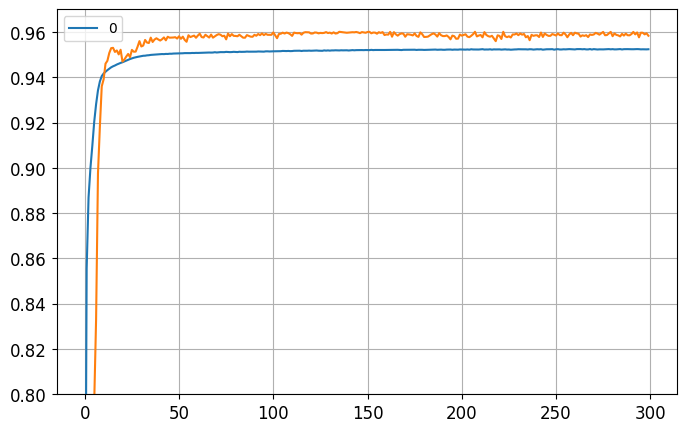

In [16]:
pd.DataFrame(history.history["rounded_accuracy"]).plot(figsize=(8, 5))
plt.plot(history.history["val_rounded_accuracy"])
plt.grid(True)
#plt.gca().set_ylim(0, 1)
#save_fig("keras_learning_curves_plot")
#plt.xlim(0,20)
plt.ylim(0.8,0.97)
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 998ms/step


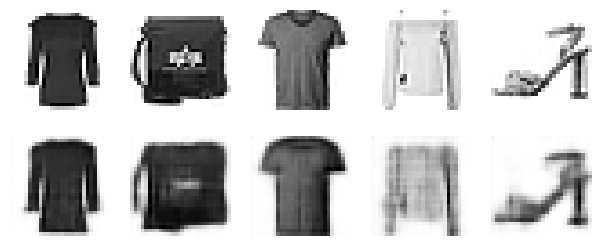

In [17]:
show_reconstructions(conv_ae)
plt.show()

Autoencoders variacionales


In [20]:
K = keras.backend
kl_divergence = keras.losses.kullback_leibler_divergence

class KLDivergenceRegularizer(keras.regularizers.Regularizer):
    def __init__(self, weight, target=0.1):
        self.weight = weight
        self.target = target
    def __call__(self, inputs):
        mean_activities = K.mean(inputs, axis=0)
        return self.weight * (
            kl_divergence(self.target, mean_activities) +
            kl_divergence(1. - self.target, 1. - mean_activities))

class Sampling(keras.layers.Layer):
    def call(self, inputs):
        mean, log_var = inputs
        return K.random_normal(tf.shape(log_var)) * K.exp(log_var / 2) + mean

In [23]:
tf.random.set_seed(42)
np.random.seed(42)

codings_size = 10

inputs = keras.layers.Input(shape=[28, 28])
z = keras.layers.Flatten()(inputs)
z = keras.layers.Dense(150, activation="selu")(z)
z = keras.layers.Dense(100, activation="selu")(z)
codings_mean = keras.layers.Dense(codings_size)(z)
codings_log_var = keras.layers.Dense(codings_size)(z)
codings = Sampling()([codings_mean, codings_log_var])
variational_encoder = keras.models.Model(
    inputs=[inputs], outputs=[codings_mean, codings_log_var, codings])

decoder_inputs = keras.layers.Input(shape=[codings_size])
x = keras.layers.Dense(100, activation="selu")(decoder_inputs)
x = keras.layers.Dense(150, activation="selu")(x)
x = keras.layers.Dense(28 * 28, activation="sigmoid")(x)
outputs = keras.layers.Reshape([28, 28])(x)
variational_decoder = keras.models.Model(inputs=[decoder_inputs], outputs=[outputs])

_, _, codings = variational_encoder(inputs)
reconstructions = variational_decoder(codings)
variational_ae = keras.models.Model(inputs=[inputs], outputs=[reconstructions])

latent_loss = -0.5 * K.sum(
    1 + codings_log_var - K.exp(codings_log_var) - K.square(codings_mean),
    axis=-1)
variational_ae.add_loss(K.mean(latent_loss) / 784.)
variational_ae.compile(loss="binary_crossentropy", optimizer="rmsprop", metrics=[rounded_accuracy])
history = variational_ae.fit(X_train, X_train, epochs=25, batch_size=128,
                             validation_data=(X_valid, X_valid))

ValueError: When providing `outputs` as a list/tuple, all values in the list/tuple must be KerasTensors. Received: outputs=[[<KerasTensor shape=(None, 28, 28), dtype=float32, sparse=False, name=keras_tensor_80>]] including invalid value [<KerasTensor shape=(None, 28, 28), dtype=float32, sparse=False, name=keras_tensor_80>] of type <class 'list'>